In [1]:
import numpy as np
import tensorflow as tf
import helpful_functions as hf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# -----encoder 2Input 10x10x16 image 64x64 pixel----- #
#encoder1
# output shape 30x30x16
encoder1_inputs = keras.Input(shape=(64, 64, 1), name="img_input1")
x = layers.Conv2D(8, 3, activation="relu")(encoder1_inputs)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder1_outputs = layers.MaxPooling2D(2)(x)

encoder1 = keras.Model(encoder1_inputs, encoder1_outputs, name="encoder1")
#encoder1.summary()

# encoder2
encoder2_inputs = keras.Input(shape=(30, 30, 16), name="img_input2")
x = layers.Conv2D(16, 3, activation="relu", padding="same")(encoder2_inputs)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, encoder2_inputs])

x = layers.Conv2D(16, 3, activation="relu")(block_2_output)
block_3_output = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_3_output)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_4_output = layers.add([x, block_3_output])

x  = layers.Conv2D(16, 3, activation="relu")(block_4_output)
encoder2_outputs= layers.Conv2D(16, 3, activation="relu")(x)

encoder2 = keras.Model(encoder2_inputs, encoder2_outputs, name="encoder2")
#encoder2.summary()

#decoder
decoder_inputs = keras.Input(shape=(10, 10, 16), name="decoder_input")
x = layers.Conv2DTranspose(16, 3, activation="relu")(decoder_inputs)
block_5_output = layers.Conv2DTranspose(16, 3, activation="relu")(x)

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_5_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_6_output = layers.add([x, block_5_output])

x = layers.UpSampling2D(2)(block_6_output)
block_7_output = layers.Conv2DTranspose(16, 3, activation="relu")(x)

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_7_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_8_output = layers.add([x, block_7_output])

x = layers.UpSampling2D(2)(block_8_output)
x = layers.Conv2DTranspose(8, 3, activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
#decoder.summary()

# autoencoder
# define 2 inputs of autoencoder
autoencoder_input1 = keras.Input(shape=(64, 64, 1), name="input_img1")
autoencoder_input2 = keras.Input(shape=(64, 64, 1), name="input_img2")

# sobel filter
sobel_image1 = tf.image.sobel_edges(autoencoder_input1)
sobel_image2 = tf.image.sobel_edges(autoencoder_input2)

# get all direction sobel image
# image 1
sobel_image1_y = sobel_image1[:,:,:,:,0] # sobel in y-direction
sobel_image1_x = sobel_image1[:,:,:,:,1] # sobel in x-direction
sobel_image1_sqrt = tf.math.sqrt(tf.math.add(tf.math.square(sobel_image1_x), tf.math.square(sobel_image1_y)))

# image 2
sobel_image2_y = sobel_image2[:,:,:,:,0] # sobel in y-direction
sobel_image2_x = sobel_image2[:,:,:,:,1] # sobel in x-direction
sobel_image2_sqrt = tf.math.sqrt(tf.math.add(tf.math.square(sobel_image2_x), tf.math.square(sobel_image2_y)))

# norm new
#img1_max = tf.reduce_max(sobel_image1_sqrt)
#img2_max = tf.reduce_max(sobel_image2_sqrt)
#sobel_image1_sqrt = sobel_image1_sqrt / img1_max
#sobel_image2_sqrt = sobel_image2_sqrt / img2_max

# encoder block
# encoder1
encoded1_img1 = encoder1(autoencoder_input1)
encoded1_img2 = encoder1(autoencoder_input2)
encoded1_img_sobel1 = encoder1(sobel_image1_sqrt)
encoded1_img_sobel2 = encoder1(sobel_image2_sqrt)
# fusion
encoded1_imgImp1 =layers.add([encoded1_img1,encoded1_img_sobel1])
encoded1_imgImp2 =layers.add([encoded1_img2,encoded1_img_sobel2])
# encoder2
encoded2_imgImp1 = encoder2(encoded1_imgImp1)
encoded2_imgImp2 = encoder2(encoded1_imgImp2)

# latent space between encoder and decoder
encoded2_imgImp3 = layers.add([encoded2_imgImp1,encoded2_imgImp2])

# decoder block
decoded_img1 = decoder(encoded2_imgImp1)
decoded_img2 = decoder(encoded2_imgImp2)
decoded_img3 = decoder(encoded2_imgImp3)

autoencoder = keras.Model(inputs=[autoencoder_input1,autoencoder_input2],
                          outputs=[decoded_img1,decoded_img2,decoded_img3], name="autoencoder")
autoencoder.summary()

Metal device set to: Apple M2


2023-04-23 17:08:51.498344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-23 17:08:51.498468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img1 (InputLayer)        [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_img2 (InputLayer)        [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (4,)                0           ['input_img1[0][0]']             
 )                                                                                                
                                                                                                  
 tf.compat.v1.shape_1 (TFOpLamb  (4,)                0           ['input_img2[0][0]']   

keras.utils.plot_model(autoencoder, "testModel_2Encoder.png", show_shapes=True)

In [3]:
# load data_set
data_set = hf.load_dataset_npz('data_set/2Inputs_64pix_3-8_ratio05.npz')
#data_set = hf.load_dataset_npz('data_set/2Inputs_64pix_3-8_ratio07.npz')
data_set = data_set.astype('float32')
x_train = data_set[:8000, :2]
y_train = data_set[:8000]
x_test = data_set[8000:, :2]
y_test = data_set[8000:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8000, 2, 64, 64, 1)
(8000, 3, 64, 64, 1)
(2000, 2, 64, 64, 1)
(2000, 3, 64, 64, 1)


In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=5,
                        verbose=1, mode='auto', restore_best_weights=True)

history = autoencoder.fit([x_train[:,0],x_train[:,1]], [y_train[:,0],y_train[:,1],y_train[:,2]], epochs=15,
                          validation_data=((x_test[:,0],x_test[:,1]), (y_test[:, 0],y_test[:, 1],y_test[:, 2])),
                          shuffle=True, batch_size=20)


Epoch 1/15


2023-04-23 17:08:57.717537: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-23 17:08:58.408758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


399/400 [============================>.] - ETA: 0s - loss: 0.0101 - decoder_loss: 0.0024 - decoder_1_loss: 0.0024 - decoder_2_loss: 0.0053

2023-04-23 17:09:16.278194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 21s 48ms/step - loss: 0.0100 - decoder_loss: 0.0024 - decoder_1_loss: 0.0024 - decoder_2_loss: 0.0053 - val_loss: 0.0038 - val_decoder_loss: 8.6782e-04 - val_decoder_1_loss: 8.4461e-04 - val_decoder_2_loss: 0.0021
Epoch 2/15
400/400 [==============================] - 18s 46ms/step - loss: 0.0024 - decoder_loss: 5.1477e-04 - decoder_1_loss: 5.1112e-04 - decoder_2_loss: 0.0014 - val_loss: 0.0021 - val_decoder_loss: 4.5022e-04 - val_decoder_1_loss: 4.2692e-04 - val_decoder_2_loss: 0.0012
Epoch 3/15
400/400 [==============================] - 18s 46ms/step - loss: 0.0018 - decoder_loss: 3.7607e-04 - decoder_1_loss: 3.7031e-04 - decoder_2_loss: 0.0011 - val_loss: 0.0018 - val_decoder_loss: 3.8705e-04 - val_decoder_1_loss: 3.6876e-04 - val_decoder_2_loss: 0.0010
Epoch 4/15
400/400 [==============================] - 18s 45ms/step - loss: 0.0015 - decoder_loss: 3.0240e-04 - decoder_1_loss: 2.9973e-04 - decoder_2_loss: 8.7096e-04 - val_loss: 0.0015 - va

# save the trained model
autoencoder.save('saved_model/sobel_15epochs_withoutNorm')

In [5]:
# make predictions
predictions = autoencoder.predict([x_test[:,0],x_test[:,1]])
np.shape(predictions)

2023-04-23 17:14:04.403800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 29ms/step


(3, 2000, 64, 64, 1)

In [6]:
mse = tf.keras.losses.MeanSquaredError()
#mse(y_test[:,3], predictions[3]).numpy()
print(f"mse is: {mse(y_test[:,2], predictions[2]).numpy()}")
ssim = tf.image.ssim(y_test[:,2], predictions[2], max_val=1.0)
ssim_mean = np.mean(ssim)
print(f"ssim is for sample {808}: {ssim[807].numpy()}")
print(f"mean of ssim is: {ssim_mean}")


mse is: 0.00046585540985688567
ssim is for sample 808: 0.9754031896591187
mean of ssim is: 0.9941601753234863


In [7]:
history_df = pd.DataFrame(history.history)
history_ssim = pd.DataFrame(ssim)
with open('output/sobel_filter/Sobelnew(15epochs)withoutNorm111.csv', 'wb') as file:
    history_df.to_csv(file)
with open('output/sobel_filter/Sobelnew_ssim(15epochs)withoutNorm111.csv', 'wb') as file:
    history_ssim.to_csv(file)

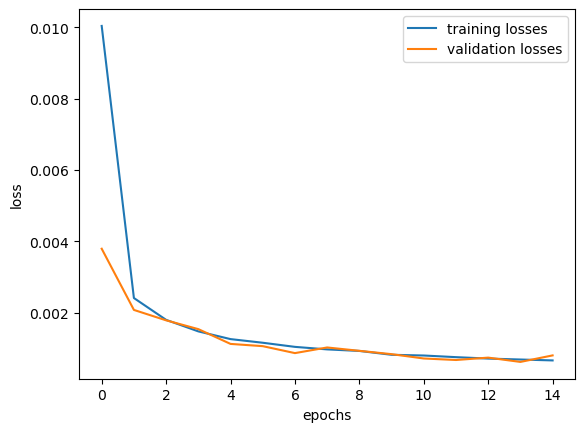

In [8]:
history_df = pd.DataFrame(history.history)
history_ssim = pd.DataFrame(ssim)

fig, ax = plt.subplots()
epochs = range(len(history_df))
loss = history_df['loss']
val_loss = history_df['val_loss']
ax.set_xlabel('epochs')  # Add an x-label to the axes.
ax.set_ylabel('loss')  # Add a y-label to the axes.

ax.plot(epochs, loss, label='training losses')
ax.plot(epochs, val_loss, label='validation losses')
ax.legend()
#ax.text(30, 0.0005, f'(30,{loss[29]})', color='b')
#ax.annotate('(30, {:.2e})'.format(loss[29]), xy=(30, loss[29]), xytext=(35, 0.0006),
 #           arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

with open('output/sobel_filter/noSobel.csv', 'wb') as file:
    history_df.to_csv(file)
with open('output/sobel_filter/noSobel_ssim.csv', 'wb') as file:
    history_ssim.to_csv(file)

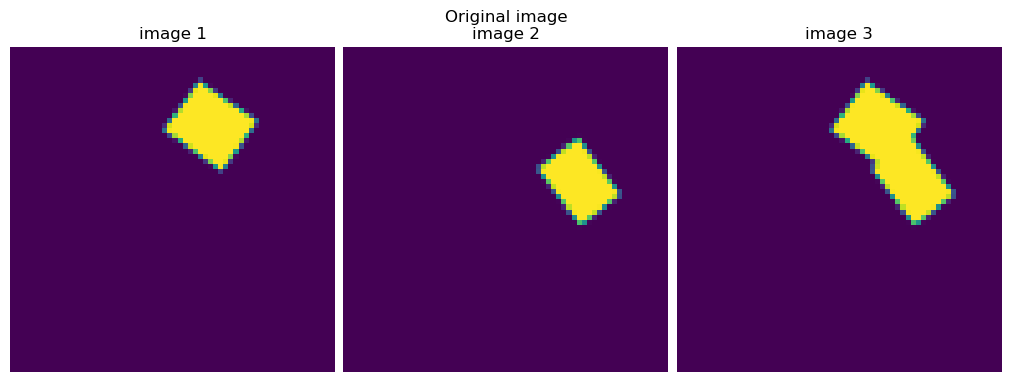

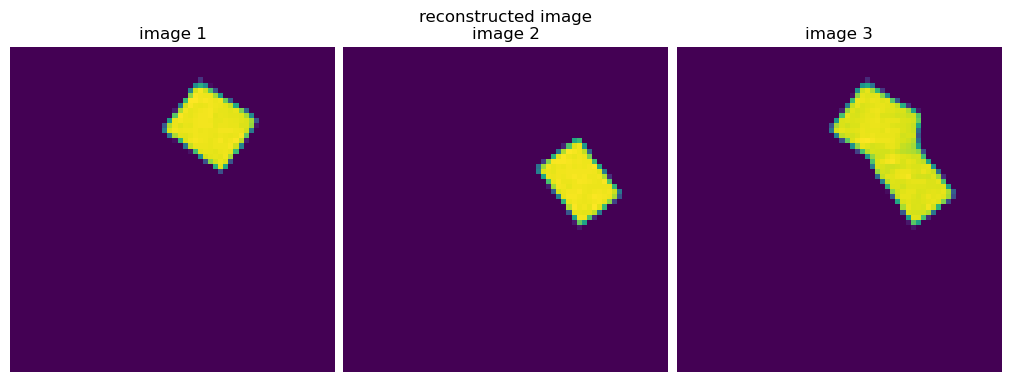

In [12]:
hf.show_image(sample_num=120, img_data1=data_set,img_data2=predictions)
#for i in range(2):
#hf.show_image(sample_num=i+1, img_data1=data_set,img_data2=predictions)

In [ ]:
n_bins = 10
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(history_ssim, n_bins, histtype='bar')
plt.show()